In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import MSELoss
import time

import warnings
warnings.filterwarnings("ignore")

from laser_jitter.data import TimeSeries, TimeSeriesSTFT
from laser_jitter.model_basic import LSTMForecaster
from laser_jitter.model import RNNTemporal, RNNSTFT, RNNSTFT_real_imag, RNNSTFT_ensemble
from laser_jitter.train import train_model

In [2]:
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

data = pd.read_csv("/home/wi73yus/focus_deviation/data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])

### TimeSeries

In [14]:
ts = TimeSeries(ts_data, smooth_params=smooth_params, train_size=0.8)

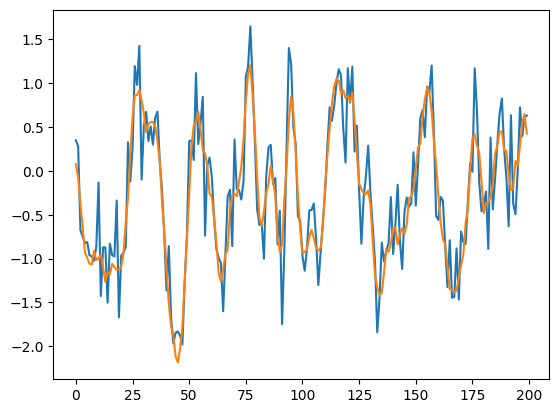

In [15]:
idx = 200
plt.figure()
plt.plot(ts.test[:idx])
plt.plot(ts.test_smooth[:idx])
plt.show()

In [20]:
i = 0
for series, series_smooth in zip([ts.train, ts.test], [ts.train_smooth, ts.test_smooth]):
    mae_low = np.mean(np.abs(series - series_smooth))
    rms_low = np.sqrt(np.mean(np.abs(series - series_smooth)**2))
    
    mae_low = ts.scaler_smooth.inverse_transform(np.array([mae_low])[:,None]).squeeze()
    rms_low = ts.scaler_smooth.inverse_transform(np.array([rms_low])[:,None]).squeeze()
    part = 'train' if i == 0 else 'test'
    print(f'{part}:')
    print(f'mae smooth: {mae_low}')
    print(f'rms smooth: {rms_low}')
    i += 1

train:
mae smooth: 0.000776172227388777
rms smooth: 0.0009461024568726797
test:
mae smooth: 0.0007626064162106429
rms smooth: 0.000931423034709334


In [5]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders
loaders_smooth = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                       dataloader_params)
trainloader_smooth, testloader_smooth = loaders_smooth

In [6]:
for (x,y), (x_smooth, y_smooth) in zip(trainloader, trainloader_smooth):
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 1]) torch.Size([64, 100, 1])


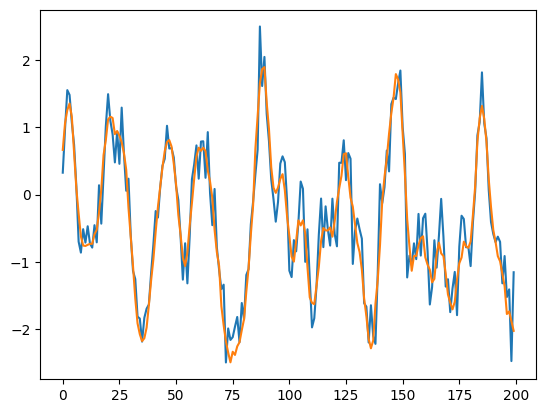

In [7]:
i = 50
idx = 200
plt.figure()
plt.plot(x[i,:idx])
plt.plot(x_smooth[i,:idx])
plt.show()

### TimeSeriesSTFT

In [15]:
stft_params = {
    'nperseg': 500, # window_length
    'fs': 1e3,
    'boundary': None,
    'noverlap': 499,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data[:10000], stft_params, train_size=0.8, filter_params=filter_params)

array([0.25 , 0.251, 0.252, ..., 7.748, 7.749, 7.75 ])

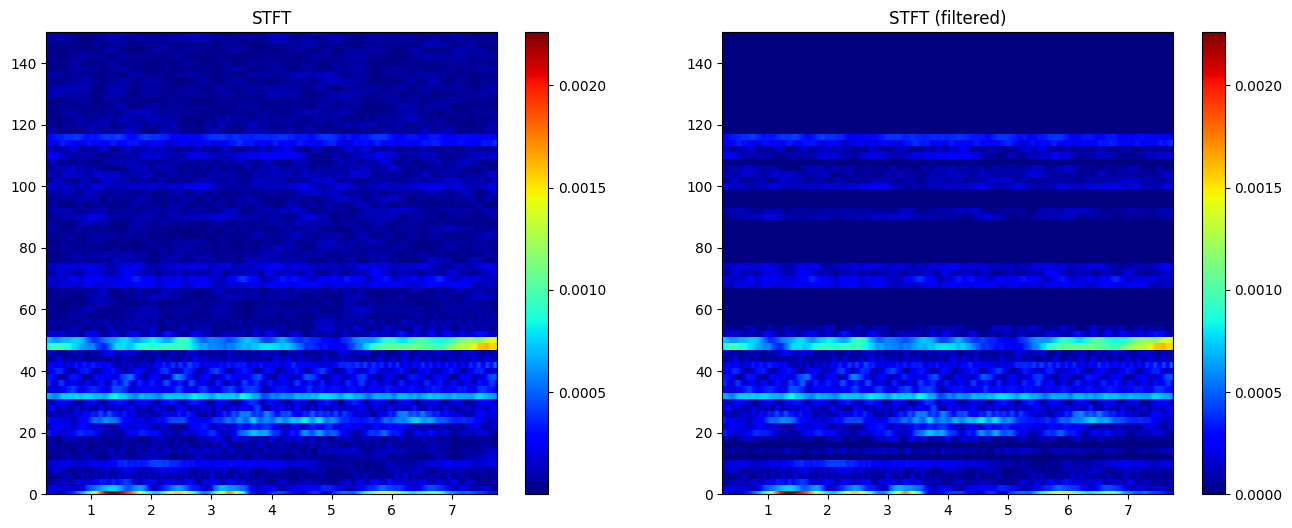

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT')


plt.subplot(122)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft_filt), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT (filtered)')
plt.show()

In [10]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [11]:
for x,y in trainloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 80]) torch.Size([64, 100, 80])


### Basic_model

In [24]:
n_features = 1
training_window = 200
prediction_window = 100
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
batch_size = 1

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': 128,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 3,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}

model = LSTMForecaster(**model_params)
x = torch.Tensor(np.random.uniform(size=(batch_size,training_window,n_features)))#.to(device)
print(x.shape)

prediction = model(x).detach().cpu().numpy()
prediction = prediction.reshape((batch_size,prediction_window,n_features))

print(prediction.shape)

torch.Size([1, 200, 1])
(1, 100, 1)


### Temporal model

In [3]:
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

ts = TimeSeries(ts_data, smooth_params=smooth_params, train_size=0.8)

training_window = 300
prediction_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 128,
    'drop_last': False,
}

loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders

loaders = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                dataloader_params)
trainloader_smooth, testloader_smooth = loaders

In [13]:
n_features = 1
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 100,
    'n_hidden_fc': 2000,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 3,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = 'models/rnn_2000_/'
# load_model = False
load_model = True

model = LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNTemporal(model_params, model, save_folder, load_model=load_model)

In [5]:
lr = 1e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [6]:
losses = model_high_level.train(trainloader_smooth, testloader_smooth,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.6357220731309203, valid: 0.37918852629332706
1 - train: 0.35654460797544385, valid: 0.33336115037572794
2 - train: 0.3187194532546841, valid: 0.29514721498407165
3 - train: 0.2923031109766882, valid: 0.2836969628416259
4 - train: 0.2812670405770912, valid: 0.2768589273608964
5 - train: 0.2682571540601918, valid: 0.26665652466231377
6 - train: 0.2538741279820927, valid: 0.2571270599447448
7 - train: 0.24061059353292966, valid: 0.2509415380913636
8 - train: 0.2309999553883662, valid: 0.24752888905590978
9 - train: 0.22165135391911522, valid: 0.2464563743821506
10 - train: 0.21251842501710672, valid: 0.24684841262883153
11 - train: 0.203891359636041, valid: 0.24888424575328827
12 - train: 0.1944211087510234, valid: 0.2524235135522382
13 - train: 0.18524531287248017, valid: 0.2559712899142298
14 - train: 0.17609436822230698, valid: 0.26147752486426257
15 - train: 0.16760802928541527, valid: 0.2631636154035042
16 - train: 0.15975961064706085, valid: 0.2685073218468962
17 - trai

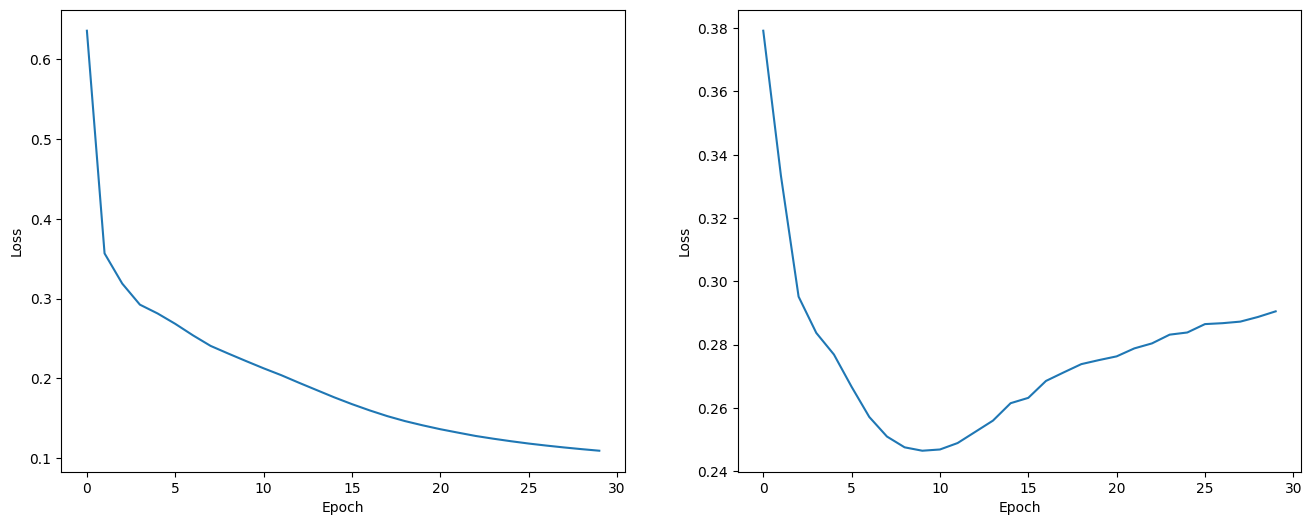

In [7]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

#### Inference

In [14]:
model = model_high_level.load_best_model()

data, metrics = model_high_level.inference_on_dataloader(testloader, testloader_smooth)
predictions, actuals, actuals_smooth = data

n_batches = len(predictions)
predictions = ts.inverse_transform_series(predictions.flatten())
predictions = predictions.reshape((n_batches,prediction_window))
actuals_smooth = ts.inverse_transform_series(actuals_smooth.flatten())
actuals_smooth = actuals_smooth.reshape((n_batches,prediction_window))
actuals = ts.inverse_transform_series(actuals.flatten(), scaler=ts.scaler)
actuals = actuals.reshape((n_batches,prediction_window))

metrics = [ts.inverse_transform_series(np.array([metric])).squeeze() for metric in metrics]

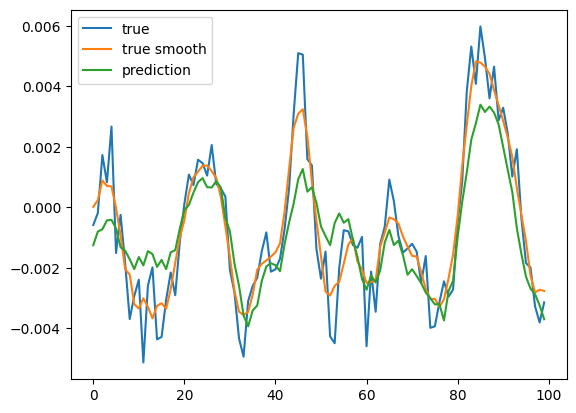

In [15]:
idx = 2000
plt.figure()
plt.plot(actuals[idx], label='true')
plt.plot(actuals_smooth[idx], label='true smooth')
plt.plot(predictions[idx], label='prediction')
plt.legend()
plt.show()

In [16]:
print(f'mae: {metrics[0]}')
print(f'rms: {metrics[1]}')

mae: 0.001063320436514914
rms: 0.0013100543292239308


In [17]:
# use_cuda = torch.cuda.is_available()
models = []
save_folder = 'models/rnn_2000/'
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 64,
        'n_hidden_fc': 2000,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNTemporal(model_params, model, save_folder, load_model=True)
    models.append(model_high_level)

In [18]:
t0 = 17500
N = 5

past_start, past_end = t0-N//2, t0+training_window+N//2 
future_start, future_end = t0+training_window+N//2, t0+training_window+N//2+prediction_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 499.3 ms
Prediction time (cuda): 1.7 ms


rms (initial): 0.0020630453994035128
rms          : 0.0014944497424701736


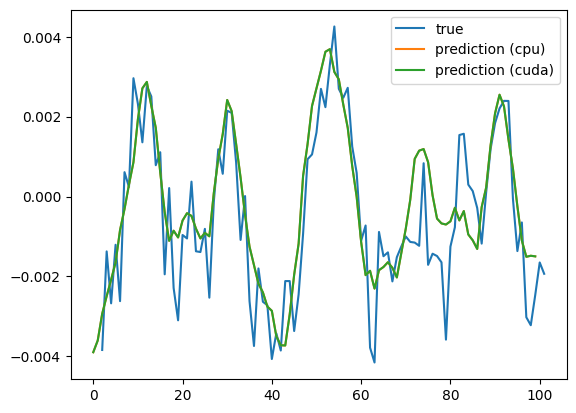

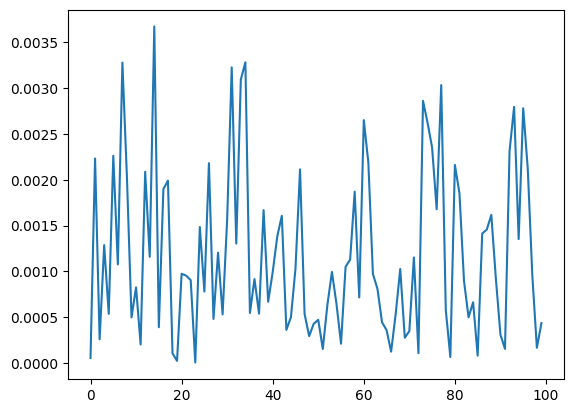

In [19]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(prediction_window)+2, series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

### Spectral model

#### One model for real/imag part of all frequency bands
TODO: how input vector changes inside LSTM network (features dimension in particular),
do we have a bottleneck regarding how many units we use?
TODO: train on stft of smoothed time series???

In [14]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params,
                    smooth_params=smooth_params)

training_window = 500
prediction_window = 200
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [15]:
n_features = len(ts.freq_filt)*2
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 64,
    'n_hidden_fc': prediction_window*2,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = 'models/rnn_stft_test_/'
load_model = False
# load_model = True

model = LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT(model_params, model, save_folder, load_model)

cuda


In [16]:
lr = 2e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [17]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.7417276953828746, valid: 0.5615039840340614
1 - train: 0.4113644103294817, valid: 0.3878270485861735
2 - train: 0.2726637664540061, valid: 0.31303406472910533
3 - train: 0.20705542944628616, valid: 0.28060038963502104
4 - train: 0.16278898606783357, valid: 0.2635626704855399
5 - train: 0.12662201519284783, valid: 0.25351192158731545


KeyboardInterrupt: 

NameError: name 'losses' is not defined

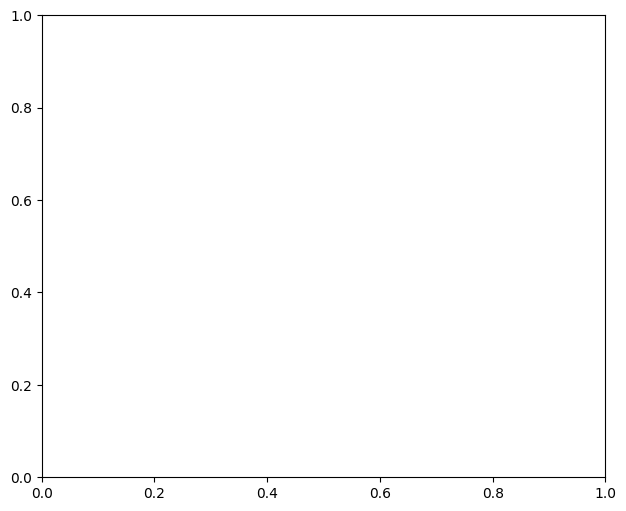

In [8]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

##### Inference

In [11]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

In [12]:
data, metrics = model_high_level.inference_on_dataloader(test, ts, sequence_params,
                                                         dataloader_params,
                                                         forecast_window)

In [13]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.0011454130290076137
rms: 0.001448921742849052


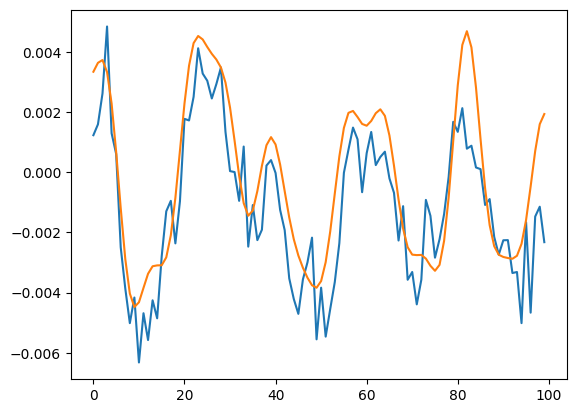

In [8]:
predictions, actuals = data

idx = 500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [9]:
# use_cuda = torch.cuda.is_available()
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 64,
        'n_hidden_fc': prediction_window*2,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT(model_params, model, save_folder, load_model=True)
    models.append(model_high_level)

In [15]:
t0 = 17500
window_len = stft_params['noverlap']
forecast_window = 100

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 52.8 ms
Prediction time (cuda): 6.4 ms


rms (initial): 0.0021564062210075357
rms          : 0.0013199502373256076


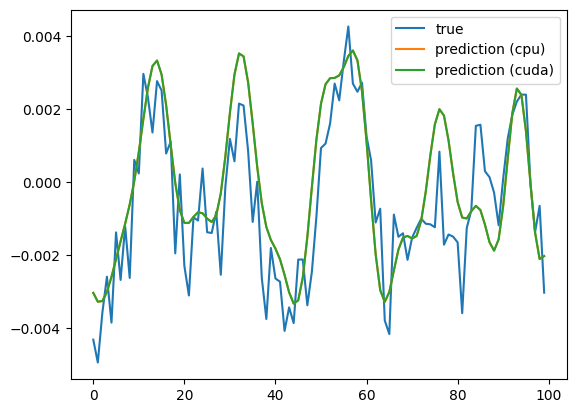

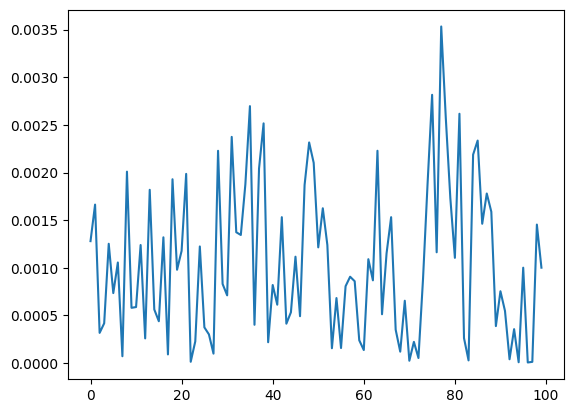

In [17]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

#### One model for real part and another model for imag part

In [9]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}
smooth_params = None

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params,
                    smooth_params=smooth_params)

training_window = 400
prediction_window = 180
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [10]:
n_features = len(ts.freq_filt)
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

n_hidden_fc = 8000
model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 100,
    'n_hidden_fc': n_hidden_fc, #prediction_window*4,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = f'models/rnn_stft_real_imag_{training_window}_{n_hidden_fc}/'
load_model = False 
load_model = True

model = None #LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT_real_imag(model_params, model, save_folder, load_model)

cuda


In [31]:
lr = 1e-4
n_epochs = 10

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = [torch.optim.AdamW(model_high_level.model[i].parameters(), lr=lr) for i in range(2)]

In [32]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.4264188460750967, valid: 0.21709939999424893
1 - train: 0.14681571675862512, valid: 0.15321792856506677
2 - train: 0.08995244158511487, valid: 0.14388672837420652
3 - train: 0.05447839419397279, valid: 0.14726456011766972
4 - train: 0.033620187113236666, valid: 0.15065167091138984
5 - train: 0.02207584463012142, valid: 0.15215587964200455
6 - train: 0.016077385403406926, valid: 0.15281979909733587
7 - train: 0.012717483766201852, valid: 0.1535047208485396


KeyboardInterrupt: 

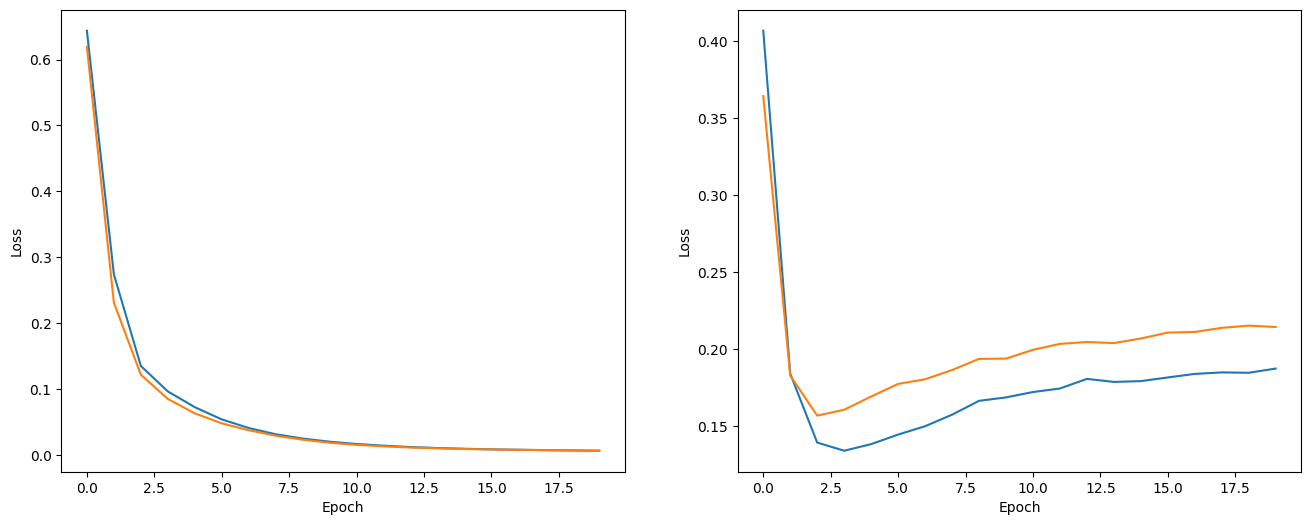

In [133]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

##### Inference

In [11]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

data, metrics = model_high_level.inference_on_dataloader(test, ts, sequence_params,
                                                         dataloader_params,
                                                         forecast_window)

In [12]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.0010670358315110207
rms: 0.001343780430033803


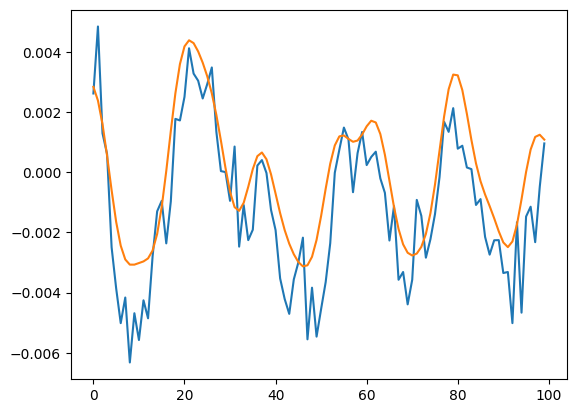

In [7]:
predictions, actuals = data

idx = 500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [27]:
# use_cuda = torch.cuda.is_available()
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 152,
        'n_hidden_fc': 152, #prediction_window*4,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT_real_imag(model_params, model, save_folder, load_model=True)
    models.append(model_high_level)

In [29]:
t0 = 17500
window_len = stft_params['noverlap']
forecast_window = 100

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    for j in range(models[i].n_models):
        models[i].model[j].eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 117.1 ms
Prediction time (cuda): 18.0 ms


rms (initial): 0.0021564062210075357
rms          : 0.00128003862929202


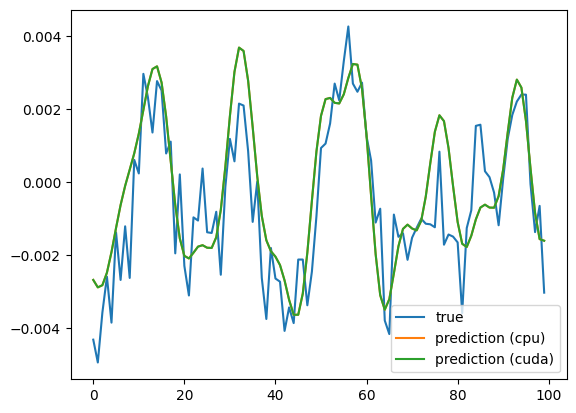

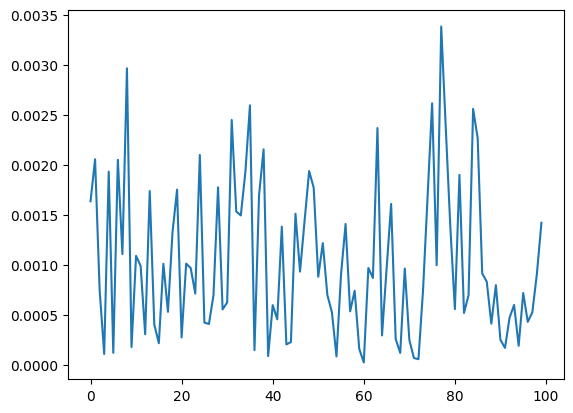

In [30]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()

#### Separate model for each frequency band

In [27]:
window_length = 500
stft_params = {
    'nperseg': window_length,
    'fs': 1e3,
    'boundary': None,
    'noverlap': window_length-1,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data, stft_params, train_size=0.8, filter_params=filter_params)
n_models = len(ts.freq_filt)

training_window = 300
prediction_window = 150
forecast_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [28]:
n_features = 2
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(device)

n_hidden_fc = 152 #prediction_window*4
model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': n_hidden_fc, #prediction_window*4,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_folder = f'models/rnn_stft_ensemble/'
load_model = False
load_model = True

model = None #LSTMForecaster(**model_params).to(device) if not load_model else None
model_high_level = RNNSTFT_ensemble(model_params, model, save_folder, load_model, n_models)

cuda


In [17]:
lr = 2e-4
n_epochs = 20

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = [torch.optim.AdamW(model_high_level.model[i].parameters(), lr=lr) for i in range(n_models)]

In [18]:
losses = model_high_level.train(trainloader, testloader,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.2799410689801081, valid: 0.1771538014596354
1 - train: 0.14812603110566297, valid: 0.15927567014226782
2 - train: 0.12806350234614244, valid: 0.15114924006963554
3 - train: 0.11703697486577684, valid: 0.14866430588531998
4 - train: 0.10930171597338056, valid: 0.1456942459893073
5 - train: 0.10339933500634516, valid: 0.14589535585168895
6 - train: 0.09822477893015925, valid: 0.14780560654214936
7 - train: 0.0938681892952837, valid: 0.14711069063703852
8 - train: 0.08988514079992319, valid: 0.14907235739345076
9 - train: 0.08615372623355963, valid: 0.15167905641579904
10 - train: 0.08241116768643776, valid: 0.1510865665039404
11 - train: 0.07886036532718232, valid: 0.15494295664271557
12 - train: 0.07493417062108583, valid: 0.1551769898224183
13 - train: 0.07086972844752301, valid: 0.1620927149252372
14 - train: 0.06724389019884658, valid: 0.16481996833189635
15 - train: 0.0633515300379416, valid: 0.16735323508135472
16 - train: 0.06006319307739853, valid: 0.1705777043450851

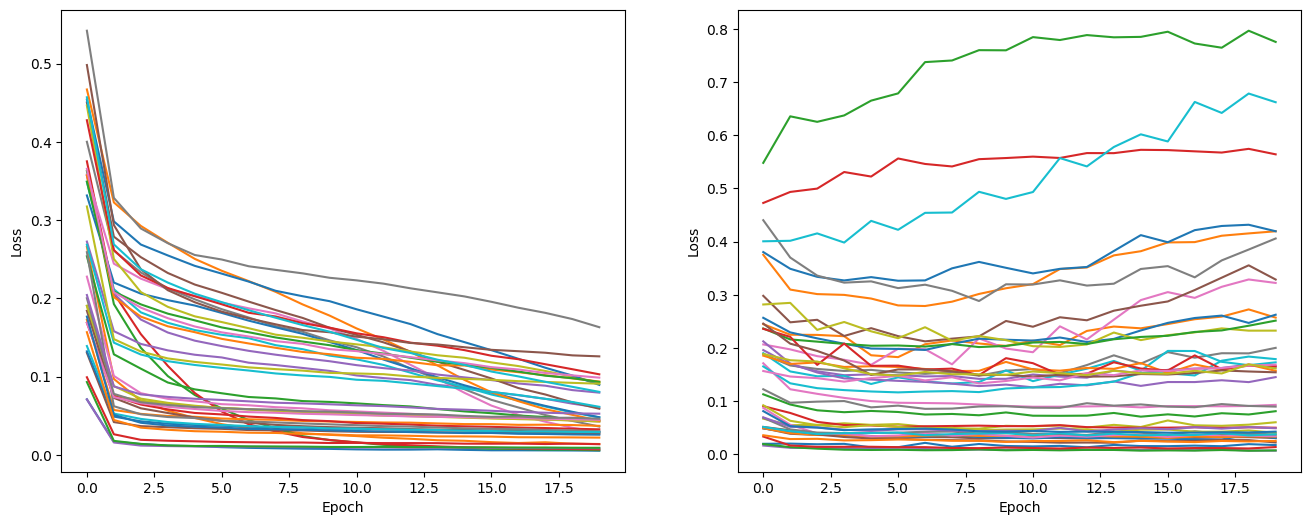

In [20]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

##### Inference

In [29]:
t0 = 16000
train = ts_data[:t0]
test = ts_data[t0:]

data, metrics = model_high_level.inference_on_dataloader(test, ts, sequence_params,
                                                         dataloader_params,
                                                         forecast_window)

In [30]:
print(f'mae: {metrics[0].numpy()}')
print(f'rms: {metrics[1].numpy()}')

mae: 0.0011881155660375953
rms: 0.0015125160571187735


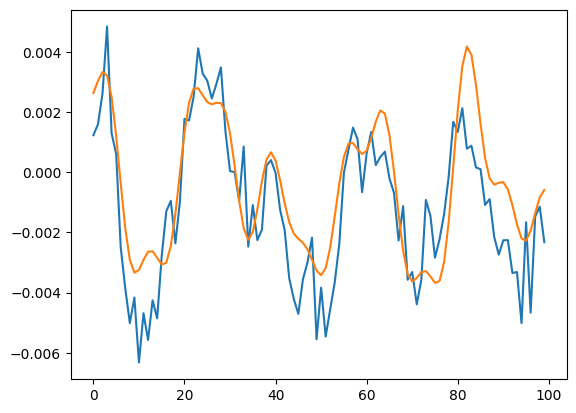

In [7]:
predictions, actuals = data

idx = 500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [8]:
# use_cuda = torch.cuda.is_available()
models = []
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 128,
        'n_hidden_fc': 152, #prediction_window*4,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = None #LSTMForecaster(**model_params).to(device)
    model_high_level = RNNSTFT_ensemble(model_params, model, save_folder, load_model=True,
                                        n_models=n_models)
    models.append(model_high_level)

In [10]:
t0 = 17500
window_len = stft_params['noverlap']
forecast_window = 100

past_start, past_end = t0-window_len, t0+training_window 
future_start, future_end = t0+training_window, t0+training_window+forecast_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    for j in range(models[i].n_models):
        models[i].model[j].eval()
    t_start = time.time()
    prediction = models[i].predict_on_series(series_past, ts, device=device)
    prediction = prediction[-prediction_window:-prediction_window+forecast_window]
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

Prediction time (cpu): 1583.8 ms
Prediction time (cuda): 74.0 ms


rms (initial): 0.0021564062210075357
rms          : 0.0012353161666914987


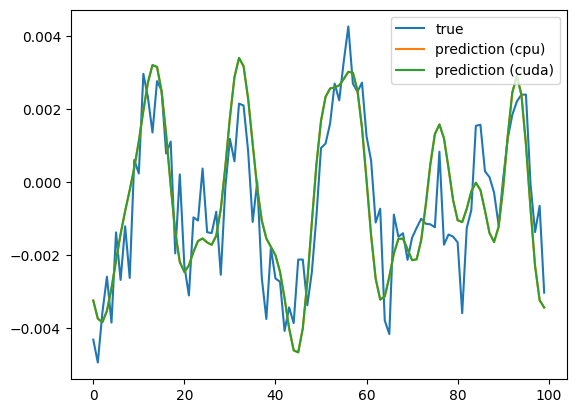

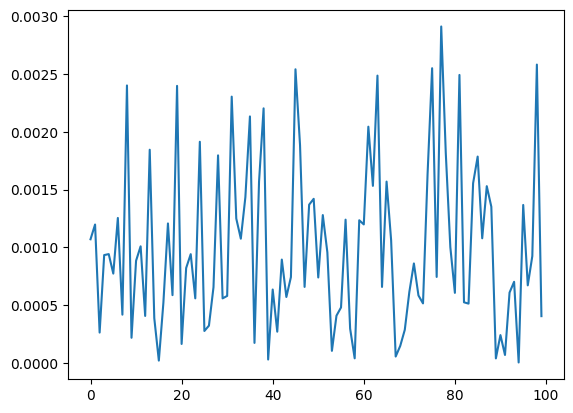

In [11]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(forecast_window), series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()